In [3]:
from interaction_inference import simulation, dataset
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import tqdm
import numpy as np

In [60]:
rng = np.random.default_rng()

# Effect of interaction & telegraph on distribution

Plot the distribution of counts as interaction / telegraph effects are applied to a birth-death / poisson model to illustrate changes. Try to understand why probabilities are so good at detecting telegraph and moments are so good at detecting interaction.

In [67]:
N = 10
r = 5
k = 5
data_BD_ind = simulation.simulate_dataset_range_BD("test", [0 for i in range(N)], rate=k, tqdm_disable=False)
data_BD_int = simulation.simulate_dataset_range_BD("test", [r for i in range(N)], rate=k, tqdm_disable=False)
data_TE_ind = simulation.simulate_dataset_range_TE("test", [0 for i in range(N)], rate=k, tqdm_disable=False)
data_TE_int = simulation.simulate_dataset_range_TE("test", [r for i in range(N)], rate=k, tqdm_disable=False)
data_BD_ind.compute_moments()
data_BD_int.compute_moments()
data_TE_ind.compute_moments()
data_TE_int.compute_moments()

100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


In [68]:
beta = rng.beta(1, 2, size=1000)
data_BD_D_ind = data_BD_ind.downsample("test", beta)
data_BD_D_int = data_BD_int.downsample("test", beta)
data_BD_D_ind.compute_moments()
data_BD_D_int.compute_moments()

In [69]:
def custom_scatter(data, L, U, color, label):

    means = []
    variances = []

    for sample, moments in data.moments_OB.items():
        
        E_1 = np.mean(moments['E_x1'])
        E_2 = np.mean(moments['E_x2'])
        
        E_sq_1 = np.mean(moments['E_x1_sq'])
        E_sq_2 = np.mean(moments['E_x2_sq'])

        means.append(E_1)
        variances.append(E_sq_1 - E_1**2)

        means.append(E_2)
        variances.append(E_sq_2 - E_2**2)

    plt.scatter(means, variances, color=color, label=label)

    L = min(L, min(means), min(variances))
    U = max(U, max(means), max(variances))

    return L, U

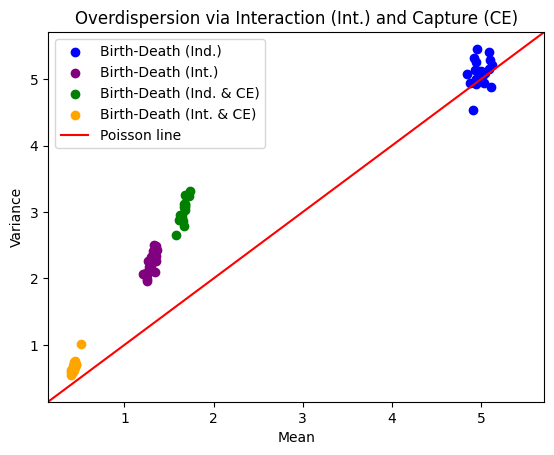

In [73]:
L = np.inf
U = 0
L, U = custom_scatter(data_BD_ind, L, U, "blue", "Birth-Death (Ind.)")
L, U = custom_scatter(data_BD_int, L, U, "purple", "Birth-Death (Int.)")
L, U = custom_scatter(data_BD_D_ind, L, U, "green", "Birth-Death (Ind. & CE)")
L, U = custom_scatter(data_BD_D_int, L, U, "orange", "Birth-Death (Int. & CE)")
#L, U = custom_scatter(data_TE_ind, L, U, "green", "Telegraph (Independent)")
#L, U = custom_scatter(data_TE_int, L, U, "orange", "Telegraph (Interacting)")
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.title("Overdispersion via Interaction (Int.) and Capture (CE)")
plt.axline([L, L], [U, U], color="red", label="Poisson line")
plt.legend()

## Under vs Over dispersion

In [209]:
def gen_poi(x, lam, alp):
    t = (1 - alp)*lam + alp*x
    return (1 - alp)*lam * (t ** (x - 1)) * np.exp(-t) / scipy.special.factorial(x)

In [210]:
lam = 5
alp = -0.1

M = 100
s = np.arange(M, dtype=float)
p = gen_poi(s, lam, alp)
p[p < 0] = 0
# normalize
# p = p / sum(p)

N = 1000
sample = rng.choice(s, N, p=p)

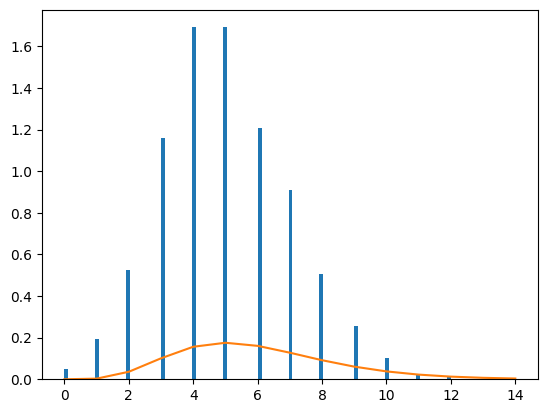

In [211]:
plt.hist(sample, density=True, bins=100);
plt.plot(scipy.stats.poisson.pmf(lam, range(15)))

In [133]:
np.mean(sample), np.var(sample)

(np.float64(4.295), np.float64(3.4359749999999996))

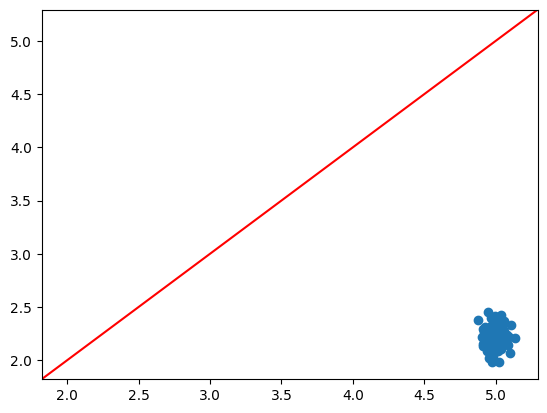

In [349]:
lam = 5
alp = -0.5

M = 20
s = np.arange(M, dtype=float)
p = gen_poi(s, lam, alp)
p[p < 0] = 0
# normalize
p = p / sum(p)

N = 1000
sample = rng.choice(s, N, p=p)

means = []
variances = []
for n in range(100):
    sample = rng.choice(s, 1000, p=p)
    means.append(np.mean(sample))
    variances.append(np.var(sample))
plt.scatter(means, variances)
L = min(min(means), min(variances))
U = max(max(means), max(variances))
plt.axline([L, L], [U, U], color="red")

# Optimization test

In [158]:
from interaction_inference import optimization

In [350]:
# settings
genes = 10
cells = 1000
lam = 5
alp = -0.5

# disrtibution
M = 20
s = np.arange(M, dtype=float)
p = gen_poi(s, lam, alp)
p[p < 0] = 0
# normalize
p = p / sum(p)

# dataframes
counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(genes)], columns=[f"Cell-{j}" for j in range(cells)])

# fill
for g in range(genes):

    # sample
    sample = rng.choice(s, cells, p=p)

    # zero other sample
    zeros = np.zeros(cells)

    # pair
    paired_sample = list(zip(sample, zeros))

    # store
    counts_df.iloc[g] = paired_sample

# construct dataset object
data = dataset.Dataset("Dispersion")

# store information
data.count_dataset = counts_df
data.cells = cells
data.gene_pairs = genes
data.beta = np.array([1.0 for j in range(cells)])

100%|██████████| 10/10 [00:00<00:00, 80.64it/s]


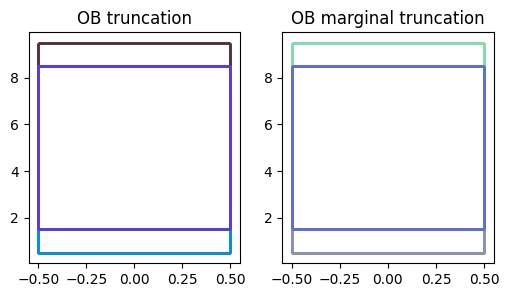

100%|██████████| 10/10 [00:00<00:00, 30.67it/s]


In [351]:
data.compute_moments(tqdm_disable=False)
data.compute_probabilities(display=True, tqdm_disable=False)
data.compute_fm(tqdm_disable=False)

In [352]:
constraints = [
    "marginal_probability_1",
    "marginal_CME_1",
    "k_deg_1"
]

opt = optimization.Optimization(data, constraints, tqdm_disable=True)

Optimization status: INFEASIBLE
Runtime: 0.008999824523925781
Optimization status: INFEASIBLE
Runtime: 0.003000020980834961
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.002000093460083008
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0009999275207519531


In [353]:
constraints = [
    "moment",
    "higher_moment",
    "marginal_CME_1",
    "k_deg_1"
]

opt = optimization.Optimization(data, constraints, tqdm_disable=True)

Optimization status: INFEASIBLE
Runtime: 0.0409998893737793
Optimization status: INFEASIBLE
Runtime: 0.026999950408935547
Optimization status: INFEASIBLE
Runtime: 0.021999835968017578
Optimization status: INFEASIBLE
Runtime: 0.021000146865844727
Optimization status: INFEASIBLE
Runtime: 0.029999971389770508
Optimization status: INFEASIBLE
Runtime: 0.012999773025512695
Optimization status: INFEASIBLE
Runtime: 0.023999929428100586
Optimization status: INFEASIBLE
Runtime: 0.02500009536743164
Optimization status: INFEASIBLE
Runtime: 0.023000001907348633
Optimization status: INFEASIBLE
Runtime: 0.023000001907348633


In [354]:
data.moments_OB 

{'sample-0': {'E_x1': array([4.937   , 5.122025]),
  'E_x2': array([0., 0.]),
  'E_x1_x2': array([0., 0.]),
  'E_x1_sq': array([26.561775, 28.453225]),
  'E_x2_sq': array([0., 0.])},
 'sample-1': {'E_x1': array([4.859975, 5.044025]),
  'E_x2': array([0., 0.]),
  'E_x1_x2': array([0., 0.]),
  'E_x1_sq': array([25.848225, 27.607275]),
  'E_x2_sq': array([0., 0.])},
 'sample-2': {'E_x1': array([4.861975, 5.05    ]),
  'E_x2': array([0., 0.]),
  'E_x1_x2': array([0., 0.]),
  'E_x1_sq': array([25.857975, 27.663175]),
  'E_x2_sq': array([0., 0.])},
 'sample-3': {'E_x1': array([4.893975, 5.078025]),
  'E_x2': array([0., 0.]),
  'E_x1_x2': array([0., 0.]),
  'E_x1_sq': array([26.1659 , 28.03405]),
  'E_x2_sq': array([0., 0.])},
 'sample-4': {'E_x1': array([4.950975, 5.139   ]),
  'E_x2': array([0., 0.]),
  'E_x1_x2': array([0., 0.]),
  'E_x1_sq': array([26.65175, 28.7272 ]),
  'E_x2_sq': array([0., 0.])},
 'sample-5': {'E_x1': array([4.96795, 5.14805]),
  'E_x2': array([0., 0.]),
  'E_x1_x2': 

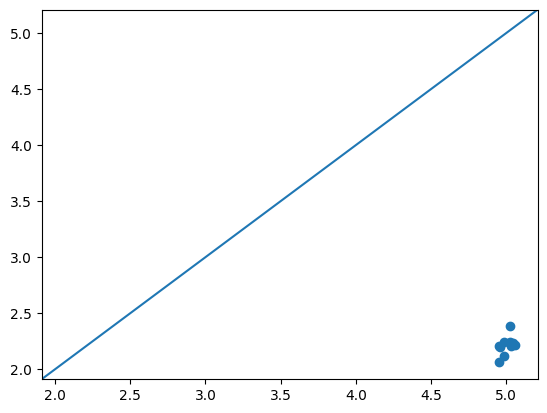

In [355]:
means = []
variances = []
for sample, moments in data.moments_OB.items():
    mean = np.mean(moments['E_x1'])
    var = np.mean(moments['E_x1_sq']) - mean**2
    means.append(mean)
    variances.append(var)
plt.scatter(means, variances)
L = min(min(means), min(variances))
U = max(max(means), max(variances))
plt.axline([L, L], [U, U])

# Test

In [257]:
# settings
genes = 10
cells = 1000

# dataframes
counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(genes)], columns=[f"Cell-{j}" for j in range(cells)])

# fill
for g in range(genes):
    counts_df.iloc[g] = list(zip(np.zeros(1000), np.zeros(1000)))

# construct dataset object
data_test = dataset.Dataset("test")

# store information
data_test.count_dataset = counts_df
data_test.cells = cells
data_test.gene_pairs = genes
data_test.beta = np.array([1.0 for j in range(cells)])

In [258]:
data_test.compute_moments()

In [332]:
# poisson mean and variance
Ex = 5
Exsq = Ex + Ex**2

# interval widths
delta = 0.2
deltasq = 2

# gamma bias
gamma = -3

for sample in data_test.moments_OB.keys():
    data_test.moments_OB[sample]['E_x1'] = np.array([Ex - delta/2, Ex + delta/2])
    data_test.moments_OB[sample]['E_x1_sq'] = np.array([Exsq - deltasq/2, Exsq + deltasq/2]) + gamma

    data_test.moment_extent_OG[sample]['max_x1_OG'] = 20

print(f"Mean = {Ex} \nVar = {(Exsq + gamma) - Ex**2}")

Mean = 5 
Var = 2


In [333]:
constraints = [
    "moment",
    "higher_moment",
    "marginal_CME_1",
    "k_deg_1"
]

opt = optimization.Optimization(data_test, constraints, tqdm_disable=True)

Optimization status: INFEASIBLE
Runtime: 0.046000003814697266
Optimization status: INFEASIBLE
Runtime: 0.03500008583068848
Optimization status: INFEASIBLE
Runtime: 0.03000020980834961
Optimization status: INFEASIBLE
Runtime: 0.026999950408935547
Optimization status: INFEASIBLE
Runtime: 0.03600001335144043
Optimization status: INFEASIBLE
Runtime: 0.03900003433227539
Optimization status: INFEASIBLE
Runtime: 0.03800010681152344
Optimization status: INFEASIBLE
Runtime: 0.03399991989135742
Optimization status: INFEASIBLE
Runtime: 0.031999826431274414
Optimization status: INFEASIBLE
Runtime: 0.023000001907348633


Finally, is infeasible when underdispersed (variance less than expected under model):

- 1st moment = 2, 2nd moment should be = 2 + 2**2 = 6 (for poisson with mean = var)
- BUT input 2nd moment = 6 + gamma = 5: INFEASIBLE
- in general any sufficiently negative gamma works

HOWEVER, even if gamma >> 0 is still feasible

# Old

In [ ]:
interaction_values = [1, 2, 3]

# number of pairs
gene_pairs = len(interaction_values)
cells = 1000
rate = 5
gene = 1

# dataframes
params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

# for each gene
for i in tqdm.tqdm(range(gene_pairs)):

    # Set reaction rate parameters
    k_on_1 = gene
    k_on_2 = gene
    k_off_1 = 1 - gene
    k_off_2 = 1 - gene
    k_tx_1 = rate
    k_tx_2 = rate
    k_deg_1 = 1
    k_deg_2 = 1
    k_reg = interaction_values[i]

    # store parameters
    params_df.iloc[i] = [k_on_1, k_on_2, k_off_1, k_off_2, k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

    params = {
        'k_on_1': k_on_1,
        'k_on_2': k_on_2,
        'k_off_1': k_off_1,
        'k_off_2': k_off_2,
        'k_tx_1': k_tx_1,
        'k_tx_2': k_tx_2,
        'k_deg_1': k_deg_1,
        'k_deg_2': k_deg_2,
        'k_reg': k_reg
    }

    # simulate sample from model
    sample = simulation.gillespie_telegraph(params, cells)

    # store counts
    counts_df.iloc[i] = sample

# construct dataset object
data = dataset.Dataset(name)

# store information
data.count_dataset = counts_df
data.param_dataset = params_df
data.cells = cells
data.gene_pairs = len(interaction_values)
data.beta = np.array([1.0 for j in range(cells)])
